## Declaração de biblioteca e outras configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

import csv

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Funções usadas no método

In [2]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

In [3]:
#Distribuição gaussiana multivarada
def multivariate_gaussian(x, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    fator = 1 / np.sqrt((2*np.pi)**n * Sigma_det)
    expo =  ( ((x-mu).T).dot( Sigma_inv ) ).dot(x-mu)
    return np.exp(-0.5*expo) / fator

#Estmação dos parâmetros
def compute_pars_gauss_multi(x,y):
    _,n = x.shape
    c = len(np.unique(y))

    #Instanciação das variáveis associadas aos parâmetros dos modelo
    mu = np.ndarray((n,c))     #vetores médio
    sigm = np.ndarray((n,n,c)) #matrizes de coveriância

    for ind in np.unique(y):
        pos = np.where(y == ind)
        mu[:,int(ind)] = np.mean( x[pos,:].reshape((len(pos[0]),n))  , axis=0)
        sigm[:,:,int(ind)] = np.cov(x[pos,:].reshape((len(pos[0]),n)) , rowvar=False)
    return mu, sigm

## Leitura dos dados (início do experimento)

In [4]:
#Arquivos com informações de treinamento e avaliação
path_data_Rotulado = 'simTreino.txt'
path_data_naoRotulado = 'simNaoRotulado.txt'

yD,xD = read_class_data(path_data_Rotulado)    #Dados de treinamento
yI,xI = read_class_data(path_data_naoRotulado) #Dados não rotulados (avaliação)

## Configurações usadas no processo
* Número máximo de autotreinamentos
* Nível de confiança exigido

In [15]:
repeticoes = 15
nivel = 0.8

## Execução do método
* O método MLC é usado neste processo
* A "confiança" é medida por $\displaystyle \frac{p(x_i|\omega_j)}{max \{ p(x_k|\omega_j) \}}, k=1,\ldots,m$

In [16]:
yDcopy = np.copy(yD); xDcopy = np.copy(xD) #Cópias para uso posterior
yIcopy = np.copy(yI); xIcopy = np.copy(xI) #Idem...
iteracao = 0

while (iteracao < repeticoes) and (len(yI) > 0):

    m,n = xI.shape; c = len(np.unique(yD)) #Número de observações e de classes
    mu,sigm = compute_pars_gauss_multi(xD,yD) #Cálculo dos parâmetros via conjunto de treino atual

    #Classificação em termos do nível de confiança
    conf = np.ndarray((m,c))
    refConf = np.zeros((c))
    for i in range(m):
        for j in range(c):
            conf[i,j] = multivariate_gaussian(xI[i,:], mu[:,j], sigm[:,:,j])
            if conf[i,j] > refConf[j]:
                refConf[j] = conf[i,j]

    #Geração de uma representação em termos de "nível de confiança" (normalização pelo máximo) 
    for j in range(c):
        conf[:,j] /= refConf[j]

    #Verificação do exemplo que ultrapassa o nível de confiança estabelecido e ajuste dos conjuntos
    itensRemove = []
    for i in range(m):
        pos1 = np.where(conf[i,:] > nivel)[0]
        if len(pos1) > 0:
            pos2 = np.argmax(conf[i,pos1])
            
            #Inclusão no conjunto de treino
            xD = np.append(xD, (xI[i,:]).reshape((1,n)), axis=0)
            yD = np.append(yD, pos1[pos2])

            #Lista de itens para remoção posterior
            itensRemove.append(i)

    #Remoção/atualização de xI e yI
    if len(itensRemove) > 0:
        xI = np.delete(xI, itensRemove, axis=0)
        yI = np.delete(yI, itensRemove)

    iteracao += 1

## Desempenho do método MLC *com* autotreinamento

In [17]:
#Treinamento
mu,sigm = compute_pars_gauss_multi(xD,yD) #Cálculo dos parâmetros
pred = np.zeros((yIcopy.shape[0]))        #Variável para armazenamento das predições
maxlike = np.ndarray((c))                 #Vetor para armazenar os valor de verossimilhança
for i in range(yIcopy.shape[0]):
    for j in range(c):
        maxlike[j] = multivariate_gaussian(xIcopy[i,:], mu[:,j], sigm[:,:,j])
    pred[i] = np.argmax(maxlike)
    
#Avaliação 
acuracia = np.count_nonzero(pred == yIcopy)/yIcopy.shape[0]
print('Acurácia: ',acuracia)

Acurácia:  0.8403041825095057


## Desempenho do método MLC *sem* autotreinamento

In [18]:
#Treinamento
mu,sigm = compute_pars_gauss_multi(xDcopy,yDcopy) #Cálculo dos parâmetros
predSem = np.zeros((yIcopy.shape[0]))                #Variável para armazenamento das predições
maxlike = np.ndarray((c))                         #Vetor para armazenar os valor de verossimilhança
for i in range(yIcopy.shape[0]):
    for j in range(c):
        maxlike[j] = multivariate_gaussian(xIcopy[i,:], mu[:,j], sigm[:,:,j])
    predSem[i] = np.argmax(maxlike)

#Avaliação
acuracia = np.count_nonzero(predSem == yIcopy)/yIcopy.shape[0]
print('Acurácia: ',acuracia)

Acurácia:  0.7756653992395437


## Visualização dos resultados

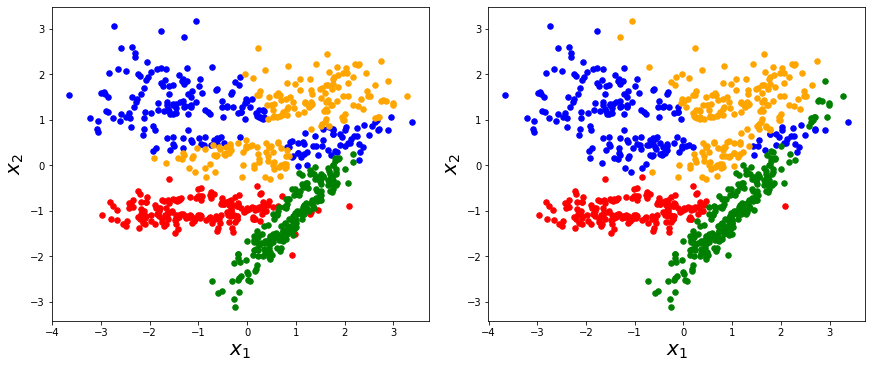

In [22]:
cores = ['red','blue','green','orange'] #Deve ser compatível com o número de classes

FS = (12,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#Subgráfico sem autotreinamento
ax = fig.add_subplot(spec[0,0])
for i in range(0,c):
    pos = np.where( np.array(predSem) == i)[0]
    ax.scatter(xIcopy[pos, 0], xIcopy[pos, 1], marker='o', c=cores[i], s=30)

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)

#Subgráfico com autotreinamento
ax = fig.add_subplot(spec[0,1])
for i in range(0,c):
    pos = np.where( np.array(pred) == i)[0]
    ax.scatter(xIcopy[pos, 0], xIcopy[pos, 1], marker='o', c=cores[i], s=30)

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)

plt.show()

In [21]:
c

4